
<h1><center id="title">DataLab Cup 3: Reverse Image Caption</center></h1>

<center id="author">Shan-Hung Wu &amp; DataLab<br/>Fall 2025</center>




<h1><center class="subtitle">Text to Image</center></h1>

<h2 id="Platform:-Kaggle">Platform: <a href="https://www.kaggle.com/competitions/2025-datalab-cup-3-reverse-image-caption/overview">Kaggle</a><a class="anchor-link" href="#Platform:-Kaggle">¶</a></h2>
<h2 id="Overview">Overview<a class="anchor-link" href="#Overview">¶</a></h2>
<p>In this work, we are interested in translating text in the form of single-sentence human-written descriptions directly into image pixels. For example, "<strong>this flower has petals that are yellow and has a ruffled stamen</strong>" and "<strong>this pink and yellow flower has a beautiful yellow center with many stamens</strong>". You have to develop a novel deep architecture and GAN formulation to effectively translate visual concepts from characters to pixels.</p>

<p>More specifically, given a set of texts, your task is to generate reasonable images with size 64x64x3 to illustrate the corresponding texts. Here we use <a href="http://www.robots.ox.ac.uk/~vgg/data/flowers/102/">Oxford-102 flower dataset</a> and its <a href="https://drive.google.com/file/d/0B0ywwgffWnLLcms2WWJQRFNSWXM/view">paired texts</a> as our training dataset.</p>

<img alt="No description has been provided for this image" src="./data/example.png"/>

<ul>
<li>7370 images as training set, where each images is annotated with at most 10 texts.</li>
<li>819 texts for testing. You must generate 1 64x64x3 image for each text.</li>
</ul>




<h2 id="Conditional-GAN">Conditional GAN<a class="anchor-link" href="#Conditional-GAN">¶</a></h2>
<p>Given a text, in order to generate the image which can illustrate it, our model must meet several requirements:</p>

<ol>
<li>Our model should have ability to understand and extract the meaning of given texts.<ul>
<li>Use RNN or other language model, such as BERT, ELMo or XLNet, to capture the meaning of text.</li>
</ul>
</li>
<li>Our model should be able to generate image.<ul>
<li>Use GAN to generate high quality image.</li>
</ul>
</li>
<li>GAN-generated image should illustrate the text.<ul>
<li>Use conditional-GAN to generate image conditioned on given text.</li>
</ul>
</li>
</ol>

<p>Generative adversarial nets can be extended to a conditional model if both the generator and discriminator are conditioned on some extra information $y$. We can perform the conditioning by feeding $y$ into both the discriminator and generator as additional input layer.</p>

<img alt="No description has been provided for this image" src="./data/cGAN.png" width="500"/>

<p>There are two motivations for using some extra information in a GAN model:</p>

<ol>
<li>Improve GAN.</li>
<li>Generate targeted image.</li>
</ol>

<p>Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality.</p>

<img alt="No description has been provided for this image" src="./data/GANCLS.jpg"/>



In [60]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
from tqdm import tqdm

import re
from IPython import display

In [61]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs



<h2 id="Preprocess-Text">Preprocess Text<a class="anchor-link" href="#Preprocess-Text">¶</a></h2>
<p>Since dealing with raw string is inefficient, we have done some data preprocessing for you:</p>

<ul>
<li>Delete text over <code>MAX_SEQ_LENGTH (20)</code>.</li>
<li>Delete all puntuation in the texts.</li>
<li>Encode each vocabulary in <code>dictionary/vocab.npy</code>.</li>
<li>Represent texts by a sequence of integer IDs.</li>
<li>Replace rare words by <code>&lt;RARE&gt;</code> token to reduce vocabulary size for more efficient training.</li>
<li>Add padding as <code>&lt;PAD&gt;</code> to each text to make sure all of them have equal length to <code>MAX_SEQ_LENGTH (20)</code>.</li>
</ul>

<p>It is worth knowing that there is no necessary to append <code>&lt;ST&gt;</code> and <code>&lt;ED&gt;</code> to each text because we don't need to generate any sequence in this task.</p>

<p>To make sure correctness of encoding of the original text, we can decode sequence vocabulary IDs by looking up the vocabulary dictionary:</p>

<ul>
<li><code>dictionary/word2Id.npy</code> is a numpy array mapping word to id.</li>
<li><code>dictionary/id2Word.npy</code> is a numpy array mapping id back to word.</li>
</ul>



In [62]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))


there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [63]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))


the flower shown has yellow anther red pistil and bright red petals.
[np.str_('9'), np.str_('1'), np.str_('82'), np.str_('5'), np.str_('11'), np.str_('70'), np.str_('20'), np.str_('31'), np.str_('3'), np.str_('29'), np.str_('20'), np.str_('2'), np.str_('5427'), np.str_('5427'), np.str_('5427'), np.str_('5427'), np.str_('5427'), np.str_('5427'), np.str_('5427'), np.str_('5427')]



<h2 id="Dataset">Dataset<a class="anchor-link" href="#Dataset">¶</a></h2>
<p>For training, the following files are in dataset folder:</p>

<ul>
<li><code>./dataset/text2ImgData.pkl</code> is a pandas dataframe with attribute 'Captions' and 'ImagePath'.<ul>
<li>'Captions' : A list of text id list contain 1 to 10 captions.</li>
<li>'ImagePath': Image path that store paired image.</li>
</ul>
</li>
<li><code>./102flowers/</code> is the directory containing all training images.</li>
<li><code>./dataset/testData.pkl</code> is a pandas a dataframe with attribute 'ID' and 'Captions', which contains testing data.</li>
</ul>



In [64]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))


There are 7370 image in training data


In [65]:
df.head(5)


,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg



<h2 id="Create-Dataset-by-Dataset-API">Create Dataset by Dataset API<a class="anchor-link" href="#Create-Dataset-by-Dataset-API">¶</a></h2>



In [66]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    caption = tf.cast(caption, tf.int32)

    return img, caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    caption = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
    caption = np.asarray(caption)
    caption = caption.astype(np.int32)
    image_path = df['ImagePath'].values
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [67]:
BATCH_SIZE = 64
dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE, training_data_generator)



<h2 id="Conditional-GAN-Model">Conditional GAN Model<a class="anchor-link" href="#Conditional-GAN-Model">¶</a></h2>
<p>As mentioned above, there are three models in this task, text encoder, generator and discriminator.</p>

<h2 id="Text-Encoder">Text Encoder<a class="anchor-link" href="#Text-Encoder">¶</a></h2>
<p>A RNN encoder that captures the meaning of input text.</p>

<ul>
<li>Input: text, which is a list of ids.</li>
<li>Output: embedding, or hidden representation of input text.</li>
</ul>



In [68]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text, which is a list of ids
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        
        # embedding with tensorflow API
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        # RNN, here we use GRU cell, another common RNN cell similar to LSTM
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')
    
    def call(self, text, hidden):
        text = self.embedding(text)
        output, state = self.gru(text, initial_state = hidden)
        return output[:, -1, :], state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))



<h2 id="Generator">Generator<a class="anchor-link" href="#Generator">¶</a></h2>
<p>A image generator which generates the target image illustrating the input text.</p>

<ul>
<li>Input: hidden representation of input text and random noise z with random seed.</li>
<li>Output: target image, which is conditioned on the given text, in size 64x64x3.</li>
</ul>



In [69]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d2 = tf.keras.layers.Dense(64*64*3)
        
    def call(self, text, noise_z):
        text = self.flatten(text)
        text = self.d1(text)
        text = tf.nn.leaky_relu(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        text_concat = self.d2(text_concat)
        
        logits = tf.reshape(text_concat, [-1, 64, 64, 3])
        output = tf.nn.tanh(logits)
        
        return logits, output



<h2 id="Discriminator">Discriminator<a class="anchor-link" href="#Discriminator">¶</a></h2>
<p>A binary classifier which can discriminate the real and fake image:</p>

<ol>
<li>Real image<ul>
<li>Input: real image and the paired text</li>
<li>Output: a floating number representing the result, which is expected to be 1.</li>
</ul>
</li>
<li>Fake Image<ul>
<li>Input: generated image and paired text</li>
<li>Output: a floating number representing the result, which is expected to be 0.</li>
</ul>
</li>
</ol>



In [70]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d_img = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)
    
    def call(self, img, text):
        text = self.flatten(text)
        text = self.d_text(text)
        text = tf.nn.leaky_relu(text)
        
        img = self.flatten(img)
        img = self.d_img(img)
        img = tf.nn.leaky_relu(img)
        
        # concatenate image with paired text
        img_text = tf.concat([text, img], axis=1)
        
        logits = self.d(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output


In [71]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 100,                           # number of epoch for demo
    'N_SAMPLE': num_training_sample,          # size of training data
    'PRINT_FREQ': 20                          # printing frequency of loss
}

In [72]:
text_encoder = TextEncoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)



<h2 id="Loss-Function-and-Optimization">Loss Function and Optimization<a class="anchor-link" href="#Loss-Function-and-Optimization">¶</a></h2>
<p>Although the conditional GAN model is quite complex, the loss function used to optimize the network is relatively simple. Actually, it is simply a binary classification task, thus we use cross entropy as our loss.</p>



In [73]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [74]:
def discriminator_loss(real_logits, fake_logits):
    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [75]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])


In [76]:
# Create checkpoint object (directory will be set later in cell 35)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [77]:
@tf.function
def train_step(real_image, caption, hidden):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        text_embed, hidden = text_encoder(caption, hidden)
        _, fake_image = generator(text_embed, noise)
        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)

        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
    return g_loss, d_loss


In [78]:
@tf.function
def test_step(caption, noise, hidden):
    text_embed, hidden = text_encoder(caption, hidden)
    _, fake_image = generator(text_embed, noise)
    return fake_image



<h2 id="Visualiztion">Visualiztion<a class="anchor-link" href="#Visualiztion">¶</a></h2>
<p>During training, we can visualize the generated image to evaluate the quality of generator. The followings are some functions helping visualization.</p>



In [79]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)


In [80]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int32)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset


<p>We always use same random seed and same senteces during training, which is more convenient for us to evaluate the quality of generated image.</p>



In [81]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])



<h2 id="Training">Training<a class="anchor-link" href="#Training">¶</a></h2>



In [82]:
from datetime import datetime

# Create a unified run directory with timestamp
run_timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
run_dir = f'runs/{run_timestamp}'

# All outputs for this run go in subdirectories
checkpoint_dir = f'{run_dir}/checkpoints'
samples_dir = f'{run_dir}/samples'
inference_dir = f'{run_dir}/inference'

# Create all directories
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(inference_dir, exist_ok=True)

print(f'Created run directory: {run_dir}')
print(f'  ├── checkpoints/ : {checkpoint_dir}')
print(f'  ├── samples/     : {samples_dir}')
print(f'  └── inference/   : {inference_dir}')

Created run directory: runs/20251115-170831
  ├── checkpoints/ : runs/20251115-170831/checkpoints
  ├── samples/     : runs/20251115-170831/samples
  └── inference/   : runs/20251115-170831/inference


In [83]:
import json

# Save hyperparameters and configuration for reproducibility
config = {
    'run_timestamp': run_timestamp,
    'run_dir': run_dir,
    'hyperparameters': hparas.copy(),
    'model_architecture': {
        'text_encoder': 'GRU',
        'generator': 'Dense',
        'discriminator': 'Dense'
    }
}

config_path = f'{run_dir}/config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f'✓ Configuration saved to: {config_path}')

✓ Configuration saved to: runs/20251115-170831/config.json


In [84]:
def train(dataset, epochs):
    # Use the run directories created in cell 35
    global run_dir, checkpoint_dir, samples_dir, inference_dir
    
    # Create checkpoint prefix
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    
    print(f'Training run: {run_dir}')
    
    # hidden state of RNN
    hidden = text_encoder.initialize_hidden_state()
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    
    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        # Progress bar for each epoch (standard approach)
        pbar = tqdm(dataset, desc=f'Epoch {epoch+1}/{hparas["N_EPOCH"]}', 
                   total=steps_per_epoch, unit='batch')
        
        for image, caption in pbar:
            g_loss, d_loss = train_step(image, caption, hidden)
            g_total_loss += g_loss
            d_total_loss += d_loss
            
            # Update progress bar with current losses
            pbar.set_postfix({
                'G_loss': f'{g_loss:.4f}',
                'D_loss': f'{d_loss:.4f}'
            })
        
        pbar.close()
        
        # Print epoch summary
        avg_g_loss = g_total_loss / steps_per_epoch
        avg_d_loss = d_total_loss / steps_per_epoch
        epoch_time = time.time() - start
        print(f'Epoch {epoch+1}: G_loss={avg_g_loss:.4f}, D_loss={avg_d_loss:.4f}, Time={epoch_time:.2f}s')
        
        # save the model
        if (epoch + 1) % 50 == 0:
            saved_path = checkpoint.save(file_prefix = checkpoint_prefix)
            print(f'  ✓ Checkpoint saved: {saved_path}')
        
        # visualization - save to timestamped directory
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed, hidden)
            save_images(fake_image, [ni, ni], f'{samples_dir}/train_{epoch+1:03d}.jpg')
            print(f'  ✓ Sample image saved')
    
    print('\n✓ Training completed!')
    print(f'All outputs saved to: {run_dir}')

In [85]:
train(dataset, hparas['N_EPOCH'])


Training run: runs/20251115-170831


Epoch 1/100: 100%|██████████| 115/115 [00:04<00:00, 26.55batch/s, G_loss=0.6512, D_loss=0.8403]


Epoch 1: G_loss=0.4152, D_loss=1.2063, Time=4.33s


Epoch 2/100: 100%|██████████| 115/115 [00:03<00:00, 32.94batch/s, G_loss=0.4807, D_loss=1.0729]


Epoch 2: G_loss=0.4624, D_loss=1.1168, Time=3.49s


Epoch 3/100: 100%|██████████| 115/115 [00:03<00:00, 33.68batch/s, G_loss=0.7134, D_loss=0.8806]


Epoch 3: G_loss=0.5907, D_loss=0.9439, Time=3.42s


Epoch 4/100: 100%|██████████| 115/115 [00:03<00:00, 32.81batch/s, G_loss=1.8228, D_loss=0.2532]


Epoch 4: G_loss=1.1668, D_loss=0.5433, Time=3.51s


Epoch 5/100: 100%|██████████| 115/115 [00:03<00:00, 32.49batch/s, G_loss=2.4588, D_loss=0.1375]


Epoch 5: G_loss=2.1769, D_loss=0.1801, Time=3.54s


Epoch 6/100: 100%|██████████| 115/115 [00:03<00:00, 33.65batch/s, G_loss=2.1536, D_loss=0.1839]


Epoch 6: G_loss=1.7697, D_loss=0.2639, Time=3.42s


Epoch 7/100: 100%|██████████| 115/115 [00:03<00:00, 32.69batch/s, G_loss=2.5279, D_loss=0.1145]


Epoch 7: G_loss=2.5959, D_loss=0.1352, Time=3.52s


Epoch 8/100: 100%|██████████| 115/115 [00:03<00:00, 32.53batch/s, G_loss=2.4501, D_loss=0.1291]


Epoch 8: G_loss=2.3769, D_loss=0.1513, Time=3.54s


Epoch 9/100: 100%|██████████| 115/115 [00:03<00:00, 33.40batch/s, G_loss=2.9581, D_loss=0.0889]


Epoch 9: G_loss=2.7185, D_loss=0.1134, Time=3.45s


Epoch 10/100: 100%|██████████| 115/115 [00:03<00:00, 32.90batch/s, G_loss=2.7670, D_loss=0.1612]


Epoch 10: G_loss=3.0044, D_loss=0.1059, Time=3.50s


Epoch 11/100: 100%|██████████| 115/115 [00:03<00:00, 32.49batch/s, G_loss=4.2729, D_loss=0.1155]


Epoch 11: G_loss=3.3133, D_loss=0.1237, Time=3.54s


Epoch 12/100: 100%|██████████| 115/115 [00:03<00:00, 32.72batch/s, G_loss=3.7535, D_loss=0.1782]


Epoch 12: G_loss=3.6664, D_loss=0.1549, Time=3.52s


Epoch 13/100: 100%|██████████| 115/115 [00:03<00:00, 31.62batch/s, G_loss=4.0313, D_loss=0.2922]


Epoch 13: G_loss=4.1556, D_loss=0.1644, Time=3.64s


Epoch 14/100: 100%|██████████| 115/115 [00:03<00:00, 33.04batch/s, G_loss=4.2195, D_loss=0.1580]


Epoch 14: G_loss=3.6987, D_loss=0.2630, Time=3.48s


Epoch 15/100: 100%|██████████| 115/115 [00:03<00:00, 33.57batch/s, G_loss=3.2063, D_loss=0.3916]


Epoch 15: G_loss=3.5290, D_loss=0.3380, Time=3.43s


Epoch 16/100: 100%|██████████| 115/115 [00:03<00:00, 33.27batch/s, G_loss=4.0681, D_loss=0.3934]


Epoch 16: G_loss=3.7126, D_loss=0.4331, Time=3.46s


Epoch 17/100: 100%|██████████| 115/115 [00:03<00:00, 32.98batch/s, G_loss=3.5080, D_loss=0.4077]


Epoch 17: G_loss=3.7465, D_loss=0.4669, Time=3.49s


Epoch 18/100: 100%|██████████| 115/115 [00:03<00:00, 33.49batch/s, G_loss=3.6118, D_loss=0.5671]


Epoch 18: G_loss=3.5503, D_loss=0.5141, Time=3.44s


Epoch 19/100: 100%|██████████| 115/115 [00:03<00:00, 29.88batch/s, G_loss=2.8263, D_loss=0.7068]


Epoch 19: G_loss=3.1126, D_loss=0.6935, Time=3.85s


Epoch 20/100: 100%|██████████| 115/115 [00:03<00:00, 33.78batch/s, G_loss=2.4283, D_loss=0.7577]


Epoch 20: G_loss=3.1994, D_loss=0.6304, Time=3.41s
  ✓ Sample image saved


Epoch 21/100: 100%|██████████| 115/115 [00:03<00:00, 32.33batch/s, G_loss=3.2150, D_loss=0.5115]


Epoch 21: G_loss=3.1360, D_loss=0.6522, Time=3.56s


Epoch 22/100: 100%|██████████| 115/115 [00:03<00:00, 31.81batch/s, G_loss=3.0212, D_loss=0.4642]


Epoch 22: G_loss=3.0020, D_loss=0.5895, Time=3.62s


Epoch 23/100: 100%|██████████| 115/115 [00:03<00:00, 31.36batch/s, G_loss=2.2774, D_loss=0.6842]


Epoch 23: G_loss=2.7164, D_loss=0.6923, Time=3.67s


Epoch 24/100: 100%|██████████| 115/115 [00:03<00:00, 33.12batch/s, G_loss=2.6443, D_loss=0.7079]


Epoch 24: G_loss=2.6128, D_loss=0.6276, Time=3.47s


Epoch 25/100: 100%|██████████| 115/115 [00:03<00:00, 32.41batch/s, G_loss=2.0441, D_loss=1.0551]


Epoch 25: G_loss=2.3357, D_loss=0.7765, Time=3.55s


Epoch 26/100: 100%|██████████| 115/115 [00:03<00:00, 32.60batch/s, G_loss=2.1247, D_loss=0.6250]


Epoch 26: G_loss=2.4266, D_loss=0.8339, Time=3.53s


Epoch 27/100: 100%|██████████| 115/115 [00:03<00:00, 33.08batch/s, G_loss=1.7527, D_loss=0.8763]


Epoch 27: G_loss=2.4037, D_loss=0.8305, Time=3.48s


Epoch 28/100: 100%|██████████| 115/115 [00:03<00:00, 33.05batch/s, G_loss=2.8486, D_loss=0.5927]


Epoch 28: G_loss=2.7503, D_loss=0.7109, Time=3.48s


Epoch 29/100: 100%|██████████| 115/115 [00:03<00:00, 33.17batch/s, G_loss=2.3862, D_loss=0.8951]


Epoch 29: G_loss=3.0036, D_loss=0.5942, Time=3.47s


Epoch 30/100: 100%|██████████| 115/115 [00:03<00:00, 32.93batch/s, G_loss=2.9568, D_loss=0.3940]


Epoch 30: G_loss=3.2122, D_loss=0.5436, Time=3.49s


Epoch 31/100: 100%|██████████| 115/115 [00:03<00:00, 32.69batch/s, G_loss=3.2087, D_loss=0.6097]


Epoch 31: G_loss=3.0821, D_loss=0.4200, Time=3.52s


Epoch 32/100: 100%|██████████| 115/115 [00:03<00:00, 32.09batch/s, G_loss=2.0993, D_loss=0.6166]


Epoch 32: G_loss=2.4744, D_loss=0.5817, Time=3.59s


Epoch 33/100: 100%|██████████| 115/115 [00:03<00:00, 33.14batch/s, G_loss=2.5482, D_loss=0.4364]


Epoch 33: G_loss=2.3849, D_loss=0.5423, Time=3.47s


Epoch 34/100: 100%|██████████| 115/115 [00:03<00:00, 32.17batch/s, G_loss=2.0301, D_loss=0.7096]


Epoch 34: G_loss=2.2745, D_loss=0.5668, Time=3.58s


Epoch 35/100: 100%|██████████| 115/115 [00:03<00:00, 32.23batch/s, G_loss=3.3758, D_loss=0.4388]


Epoch 35: G_loss=2.0385, D_loss=0.7233, Time=3.57s


Epoch 36/100: 100%|██████████| 115/115 [00:03<00:00, 32.27batch/s, G_loss=1.7409, D_loss=0.9405]


Epoch 36: G_loss=2.1668, D_loss=0.6854, Time=3.57s


Epoch 37/100: 100%|██████████| 115/115 [00:03<00:00, 33.48batch/s, G_loss=1.7753, D_loss=0.7204]


Epoch 37: G_loss=1.9514, D_loss=0.7090, Time=3.44s


Epoch 38/100: 100%|██████████| 115/115 [00:03<00:00, 32.48batch/s, G_loss=2.0936, D_loss=0.7411]


Epoch 38: G_loss=1.7642, D_loss=0.8080, Time=3.54s


Epoch 39/100: 100%|██████████| 115/115 [00:03<00:00, 32.82batch/s, G_loss=1.7558, D_loss=0.7784]


Epoch 39: G_loss=1.7872, D_loss=0.7719, Time=3.51s


Epoch 40/100: 100%|██████████| 115/115 [00:03<00:00, 32.91batch/s, G_loss=1.4484, D_loss=0.9078]


Epoch 40: G_loss=1.5834, D_loss=0.8527, Time=3.50s
  ✓ Sample image saved


Epoch 41/100: 100%|██████████| 115/115 [00:03<00:00, 32.73batch/s, G_loss=1.5305, D_loss=0.8426]


Epoch 41: G_loss=1.5904, D_loss=0.8615, Time=3.51s


Epoch 42/100: 100%|██████████| 115/115 [00:03<00:00, 32.73batch/s, G_loss=1.4673, D_loss=0.9408]


Epoch 42: G_loss=1.5003, D_loss=0.9490, Time=3.51s


Epoch 43/100: 100%|██████████| 115/115 [00:03<00:00, 32.36batch/s, G_loss=2.1225, D_loss=0.6513]


Epoch 43: G_loss=1.6147, D_loss=0.8470, Time=3.56s


Epoch 44/100: 100%|██████████| 115/115 [00:03<00:00, 32.70batch/s, G_loss=2.1252, D_loss=0.6623]


Epoch 44: G_loss=1.4994, D_loss=0.9816, Time=3.52s


Epoch 45/100: 100%|██████████| 115/115 [00:03<00:00, 32.17batch/s, G_loss=1.1646, D_loss=1.1005]


Epoch 45: G_loss=1.7496, D_loss=0.8241, Time=3.58s


Epoch 46/100: 100%|██████████| 115/115 [00:03<00:00, 32.32batch/s, G_loss=1.9203, D_loss=0.6565]


Epoch 46: G_loss=1.6226, D_loss=0.8290, Time=3.56s


Epoch 47/100: 100%|██████████| 115/115 [00:03<00:00, 31.83batch/s, G_loss=1.3510, D_loss=1.0104]


Epoch 47: G_loss=1.4284, D_loss=1.0766, Time=3.62s


Epoch 48/100: 100%|██████████| 115/115 [00:03<00:00, 31.63batch/s, G_loss=1.0859, D_loss=1.3182]


Epoch 48: G_loss=1.5528, D_loss=0.9717, Time=3.64s


Epoch 49/100: 100%|██████████| 115/115 [00:03<00:00, 32.71batch/s, G_loss=1.5212, D_loss=0.9569]


Epoch 49: G_loss=1.5861, D_loss=1.0274, Time=3.52s


Epoch 50/100: 100%|██████████| 115/115 [00:03<00:00, 32.64batch/s, G_loss=1.6109, D_loss=1.0437]


Epoch 50: G_loss=1.6591, D_loss=0.9619, Time=3.53s
  ✓ Checkpoint saved: runs/20251115-170831/checkpoints/ckpt-1


Epoch 51/100: 100%|██████████| 115/115 [00:03<00:00, 32.62batch/s, G_loss=1.6853, D_loss=1.0704]


Epoch 51: G_loss=1.5625, D_loss=1.0475, Time=3.53s


Epoch 52/100: 100%|██████████| 115/115 [00:03<00:00, 31.96batch/s, G_loss=2.0129, D_loss=0.6699]


Epoch 52: G_loss=1.8972, D_loss=0.7867, Time=3.60s


Epoch 53/100: 100%|██████████| 115/115 [00:03<00:00, 30.52batch/s, G_loss=2.0219, D_loss=0.6751]


Epoch 53: G_loss=2.1118, D_loss=0.7100, Time=3.77s


Epoch 54/100: 100%|██████████| 115/115 [00:03<00:00, 31.18batch/s, G_loss=1.7195, D_loss=0.9077]


Epoch 54: G_loss=1.8257, D_loss=0.7551, Time=3.69s


Epoch 55/100: 100%|██████████| 115/115 [00:03<00:00, 31.99batch/s, G_loss=1.2996, D_loss=1.1255]


Epoch 55: G_loss=1.8574, D_loss=0.7705, Time=3.60s


Epoch 56/100: 100%|██████████| 115/115 [00:03<00:00, 31.82batch/s, G_loss=1.5928, D_loss=1.0247]


Epoch 56: G_loss=1.6519, D_loss=0.8582, Time=3.62s


Epoch 57/100: 100%|██████████| 115/115 [00:03<00:00, 32.57batch/s, G_loss=1.5458, D_loss=0.6869]


Epoch 57: G_loss=1.4849, D_loss=0.9413, Time=3.53s


Epoch 58/100: 100%|██████████| 115/115 [00:03<00:00, 32.78batch/s, G_loss=1.6690, D_loss=0.7890]


Epoch 58: G_loss=1.4882, D_loss=1.0177, Time=3.51s


Epoch 59/100: 100%|██████████| 115/115 [00:03<00:00, 31.21batch/s, G_loss=1.9121, D_loss=0.6479]


Epoch 59: G_loss=1.8679, D_loss=0.8410, Time=3.69s


Epoch 60/100: 100%|██████████| 115/115 [00:03<00:00, 32.82batch/s, G_loss=1.6125, D_loss=0.8510]


Epoch 60: G_loss=1.6000, D_loss=0.8625, Time=3.51s
  ✓ Sample image saved


Epoch 61/100: 100%|██████████| 115/115 [00:03<00:00, 32.87batch/s, G_loss=2.0223, D_loss=0.6667]


Epoch 61: G_loss=1.8061, D_loss=0.7628, Time=3.50s


Epoch 62/100: 100%|██████████| 115/115 [00:03<00:00, 32.81batch/s, G_loss=1.8902, D_loss=0.6343]


Epoch 62: G_loss=1.4511, D_loss=1.0162, Time=3.51s


Epoch 63/100: 100%|██████████| 115/115 [00:03<00:00, 32.90batch/s, G_loss=1.5762, D_loss=1.0371]


Epoch 63: G_loss=1.5166, D_loss=0.9516, Time=3.50s


Epoch 64/100: 100%|██████████| 115/115 [00:03<00:00, 33.23batch/s, G_loss=1.3908, D_loss=0.9940]


Epoch 64: G_loss=1.5488, D_loss=0.9996, Time=3.46s


Epoch 65/100: 100%|██████████| 115/115 [00:03<00:00, 32.43batch/s, G_loss=1.6679, D_loss=0.8380]


Epoch 65: G_loss=1.5655, D_loss=1.1313, Time=3.55s


Epoch 66/100: 100%|██████████| 115/115 [00:03<00:00, 32.59batch/s, G_loss=1.6263, D_loss=0.8668]


Epoch 66: G_loss=1.8651, D_loss=0.8348, Time=3.53s


Epoch 67/100: 100%|██████████| 115/115 [00:03<00:00, 33.14batch/s, G_loss=1.5516, D_loss=0.6900]


Epoch 67: G_loss=1.5241, D_loss=0.9577, Time=3.47s


Epoch 68/100: 100%|██████████| 115/115 [00:03<00:00, 33.03batch/s, G_loss=2.0298, D_loss=0.6143]


Epoch 68: G_loss=2.0015, D_loss=0.6503, Time=3.48s


Epoch 69/100: 100%|██████████| 115/115 [00:03<00:00, 33.79batch/s, G_loss=1.6432, D_loss=0.7648]


Epoch 69: G_loss=1.4854, D_loss=0.9351, Time=3.40s


Epoch 70/100: 100%|██████████| 115/115 [00:03<00:00, 32.36batch/s, G_loss=1.0326, D_loss=1.2557]


Epoch 70: G_loss=1.6195, D_loss=0.7706, Time=3.56s


Epoch 71/100: 100%|██████████| 115/115 [00:03<00:00, 33.65batch/s, G_loss=1.3946, D_loss=0.7867]


Epoch 71: G_loss=1.4092, D_loss=0.8726, Time=3.42s


Epoch 72/100: 100%|██████████| 115/115 [00:03<00:00, 32.17batch/s, G_loss=1.7687, D_loss=0.6911]


Epoch 72: G_loss=1.3024, D_loss=1.0355, Time=3.58s


Epoch 73/100: 100%|██████████| 115/115 [00:03<00:00, 32.61batch/s, G_loss=1.2916, D_loss=0.8834]


Epoch 73: G_loss=1.3251, D_loss=1.0193, Time=3.53s


Epoch 74/100: 100%|██████████| 115/115 [00:03<00:00, 33.13batch/s, G_loss=1.1849, D_loss=1.1279]


Epoch 74: G_loss=1.3628, D_loss=1.0155, Time=3.47s


Epoch 75/100: 100%|██████████| 115/115 [00:03<00:00, 33.34batch/s, G_loss=1.3452, D_loss=0.9605]


Epoch 75: G_loss=1.5416, D_loss=0.9188, Time=3.45s


Epoch 76/100: 100%|██████████| 115/115 [00:03<00:00, 32.15batch/s, G_loss=2.1053, D_loss=0.6023]


Epoch 76: G_loss=1.5131, D_loss=0.9870, Time=3.58s


Epoch 77/100: 100%|██████████| 115/115 [00:03<00:00, 31.94batch/s, G_loss=1.2188, D_loss=1.0111]


Epoch 77: G_loss=1.7099, D_loss=0.9158, Time=3.60s


Epoch 78/100: 100%|██████████| 115/115 [00:03<00:00, 33.10batch/s, G_loss=1.8845, D_loss=0.8621]


Epoch 78: G_loss=1.8386, D_loss=0.8393, Time=3.48s


Epoch 79/100: 100%|██████████| 115/115 [00:03<00:00, 32.67batch/s, G_loss=2.0959, D_loss=0.7787]


Epoch 79: G_loss=1.7150, D_loss=0.8623, Time=3.52s


Epoch 80/100: 100%|██████████| 115/115 [00:03<00:00, 32.10batch/s, G_loss=2.2305, D_loss=0.5554]


Epoch 80: G_loss=1.7857, D_loss=0.7712, Time=3.59s
  ✓ Sample image saved


Epoch 81/100: 100%|██████████| 115/115 [00:03<00:00, 32.56batch/s, G_loss=1.5055, D_loss=0.8147]


Epoch 81: G_loss=1.6890, D_loss=0.7869, Time=3.54s


Epoch 82/100: 100%|██████████| 115/115 [00:03<00:00, 32.97batch/s, G_loss=1.6024, D_loss=0.8287]


Epoch 82: G_loss=1.3430, D_loss=0.9980, Time=3.49s


Epoch 83/100: 100%|██████████| 115/115 [00:03<00:00, 32.07batch/s, G_loss=1.7531, D_loss=0.6406]


Epoch 83: G_loss=1.3602, D_loss=0.9912, Time=3.59s


Epoch 84/100: 100%|██████████| 115/115 [00:03<00:00, 33.46batch/s, G_loss=1.3807, D_loss=0.9046]


Epoch 84: G_loss=1.4288, D_loss=0.9926, Time=3.44s


Epoch 85/100: 100%|██████████| 115/115 [00:03<00:00, 33.30batch/s, G_loss=2.1122, D_loss=0.6424]


Epoch 85: G_loss=1.5017, D_loss=1.0926, Time=3.45s


Epoch 86/100: 100%|██████████| 115/115 [00:03<00:00, 33.36batch/s, G_loss=1.0702, D_loss=1.2903]


Epoch 86: G_loss=1.6457, D_loss=1.0725, Time=3.45s


Epoch 87/100: 100%|██████████| 115/115 [00:03<00:00, 32.57batch/s, G_loss=1.3510, D_loss=0.9430]


Epoch 87: G_loss=1.8953, D_loss=0.8495, Time=3.53s


Epoch 88/100: 100%|██████████| 115/115 [00:03<00:00, 33.35batch/s, G_loss=1.7233, D_loss=0.8645]


Epoch 88: G_loss=1.5918, D_loss=0.9527, Time=3.45s


Epoch 89/100: 100%|██████████| 115/115 [00:03<00:00, 33.01batch/s, G_loss=1.4938, D_loss=0.8087]


Epoch 89: G_loss=1.8676, D_loss=0.7792, Time=3.48s


Epoch 90/100: 100%|██████████| 115/115 [00:03<00:00, 32.99batch/s, G_loss=1.4190, D_loss=0.9648]


Epoch 90: G_loss=1.4847, D_loss=0.9645, Time=3.49s


Epoch 91/100: 100%|██████████| 115/115 [00:03<00:00, 32.23batch/s, G_loss=2.6527, D_loss=0.4359]


Epoch 91: G_loss=1.7729, D_loss=0.7889, Time=3.57s


Epoch 92/100: 100%|██████████| 115/115 [00:03<00:00, 32.68batch/s, G_loss=1.7887, D_loss=0.6665]


Epoch 92: G_loss=1.5231, D_loss=0.9156, Time=3.52s


Epoch 93/100: 100%|██████████| 115/115 [00:03<00:00, 32.27batch/s, G_loss=1.2879, D_loss=1.0371]


Epoch 93: G_loss=1.5713, D_loss=0.8394, Time=3.56s


Epoch 94/100: 100%|██████████| 115/115 [00:03<00:00, 33.19batch/s, G_loss=1.3513, D_loss=0.8673]


Epoch 94: G_loss=1.4550, D_loss=0.9157, Time=3.47s


Epoch 95/100: 100%|██████████| 115/115 [00:03<00:00, 32.04batch/s, G_loss=1.1814, D_loss=1.1805]


Epoch 95: G_loss=1.1757, D_loss=1.2041, Time=3.59s


Epoch 96/100: 100%|██████████| 115/115 [00:03<00:00, 32.41batch/s, G_loss=1.1896, D_loss=1.4051]


Epoch 96: G_loss=1.2579, D_loss=1.2317, Time=3.55s


Epoch 97/100: 100%|██████████| 115/115 [00:03<00:00, 31.95batch/s, G_loss=2.0607, D_loss=0.6808]


Epoch 97: G_loss=1.3634, D_loss=1.1909, Time=3.60s


Epoch 98/100: 100%|██████████| 115/115 [00:03<00:00, 32.15batch/s, G_loss=1.5175, D_loss=0.9216]


Epoch 98: G_loss=1.5759, D_loss=1.0876, Time=3.58s


Epoch 99/100: 100%|██████████| 115/115 [00:03<00:00, 32.87batch/s, G_loss=1.8800, D_loss=0.6181]


Epoch 99: G_loss=1.8471, D_loss=0.9433, Time=3.50s


Epoch 100/100: 100%|██████████| 115/115 [00:03<00:00, 32.96batch/s, G_loss=1.9019, D_loss=0.7668]


Epoch 100: G_loss=1.9924, D_loss=0.7937, Time=3.49s
  ✓ Checkpoint saved: runs/20251115-170831/checkpoints/ckpt-2
  ✓ Sample image saved

✓ Training completed!
All outputs saved to: runs/20251115-170831



<h1><center class="subtitle">Evaluation</center></h1>

<p><code>dataset/testData.pkl</code> is a pandas dataframe containing testing text with attributes 'ID' and 'Captions'.</p>

<ul>
<li>'ID': text ID used to name generated image.</li>
<li>'Captions': text used as condition to generate image.</li>
</ul>

<p>For each captions, you need to generate <strong>inference_ID.png</strong> to evaluate quality of generated image. You must name the generated image in this format, otherwise we cannot evaluate your images.</p>




<h2 id="Testing-Dataset">Testing Dataset<a class="anchor-link" href="#Testing-Dataset">¶</a></h2>
<p>If you change anything during preprocessing of training dataset, you must make sure same operations have be done in testing dataset.</p>



In [86]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int32)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [87]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)


In [88]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])



<h2 id="Inferece">Inferece<a class="anchor-link" href="#Inferece">¶</a></h2>



In [89]:
# Inference directory is already created by the train() function
# No need to create it again here

In [90]:
def inference(dataset):
    hidden = text_encoder.initialize_hidden_state()
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    total_images = 0
    
    # Progress bar for inference
    pbar = tqdm(total=NUM_TEST, desc='Generating images', unit='img')
    
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed, hidden)
        step += 1
        
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave(f'{inference_dir}/inference_{idx[i]:04d}.jpg', fake_image[i].numpy()*0.5 + 0.5)
            total_images += 1
            pbar.update(1)
    
    pbar.close()
    print(f'\n✓ Generated {total_images} images in {time.time()-start:.4f} sec')
    print(f'✓ Images saved to: {inference_dir}')

In [91]:
# Restore the latest checkpoint instead of hardcoding ckpt-1
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f'✓ Restored checkpoint: {latest_checkpoint}')
else:
    print('⚠ No checkpoint found, using untrained model')

✓ Restored checkpoint: runs/20251115-170831/checkpoints/ckpt-2


In [92]:
inference(testing_dataset)


Generating images: 832img [00:00, 1615.42img/s]                        


✓ Generated 832 images in 0.5158 sec
✓ Images saved to: runs/20251115-170831/inference


In [93]:
# Run evaluation script to generate score.csv
# Note: This must be run from the testing directory because inception_score.py uses relative paths
# Arguments: [inference_dir] [output_csv] [batch_size]
# Batch size must be 1, 2, 3, 7, 9, 21, or 39 to avoid remainder (819 test images)

# Save score.csv inside the run directory
!cd testing && python inception_score.py ../{inference_dir}/ ../{run_dir}/score.csv 39

I0000 00:00:1763198068.617927 3252042 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20194 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
1 Physical GPUs, 1 Logical GPUs
EVALUATION RESULTS
Inception Score (diversity): 1.0000
Average Cosine Similarity: 0.9002
Average Final Score: 1.4002
Min Score: 1.1895
Max Score: 1.6472
Total images evaluated: 819
--------------Evaluation Success-----------------


## Visualize Generated Images

Below we randomly sample 20 images from our generated test results to visually inspect the quality and diversity of the model's outputs.


<h1><center class="subtitle">Demo</center></h1>

<p>We demonstrate the capability of our model (TA80) to generate plausible images of flowers from detailed text descriptions.</p>



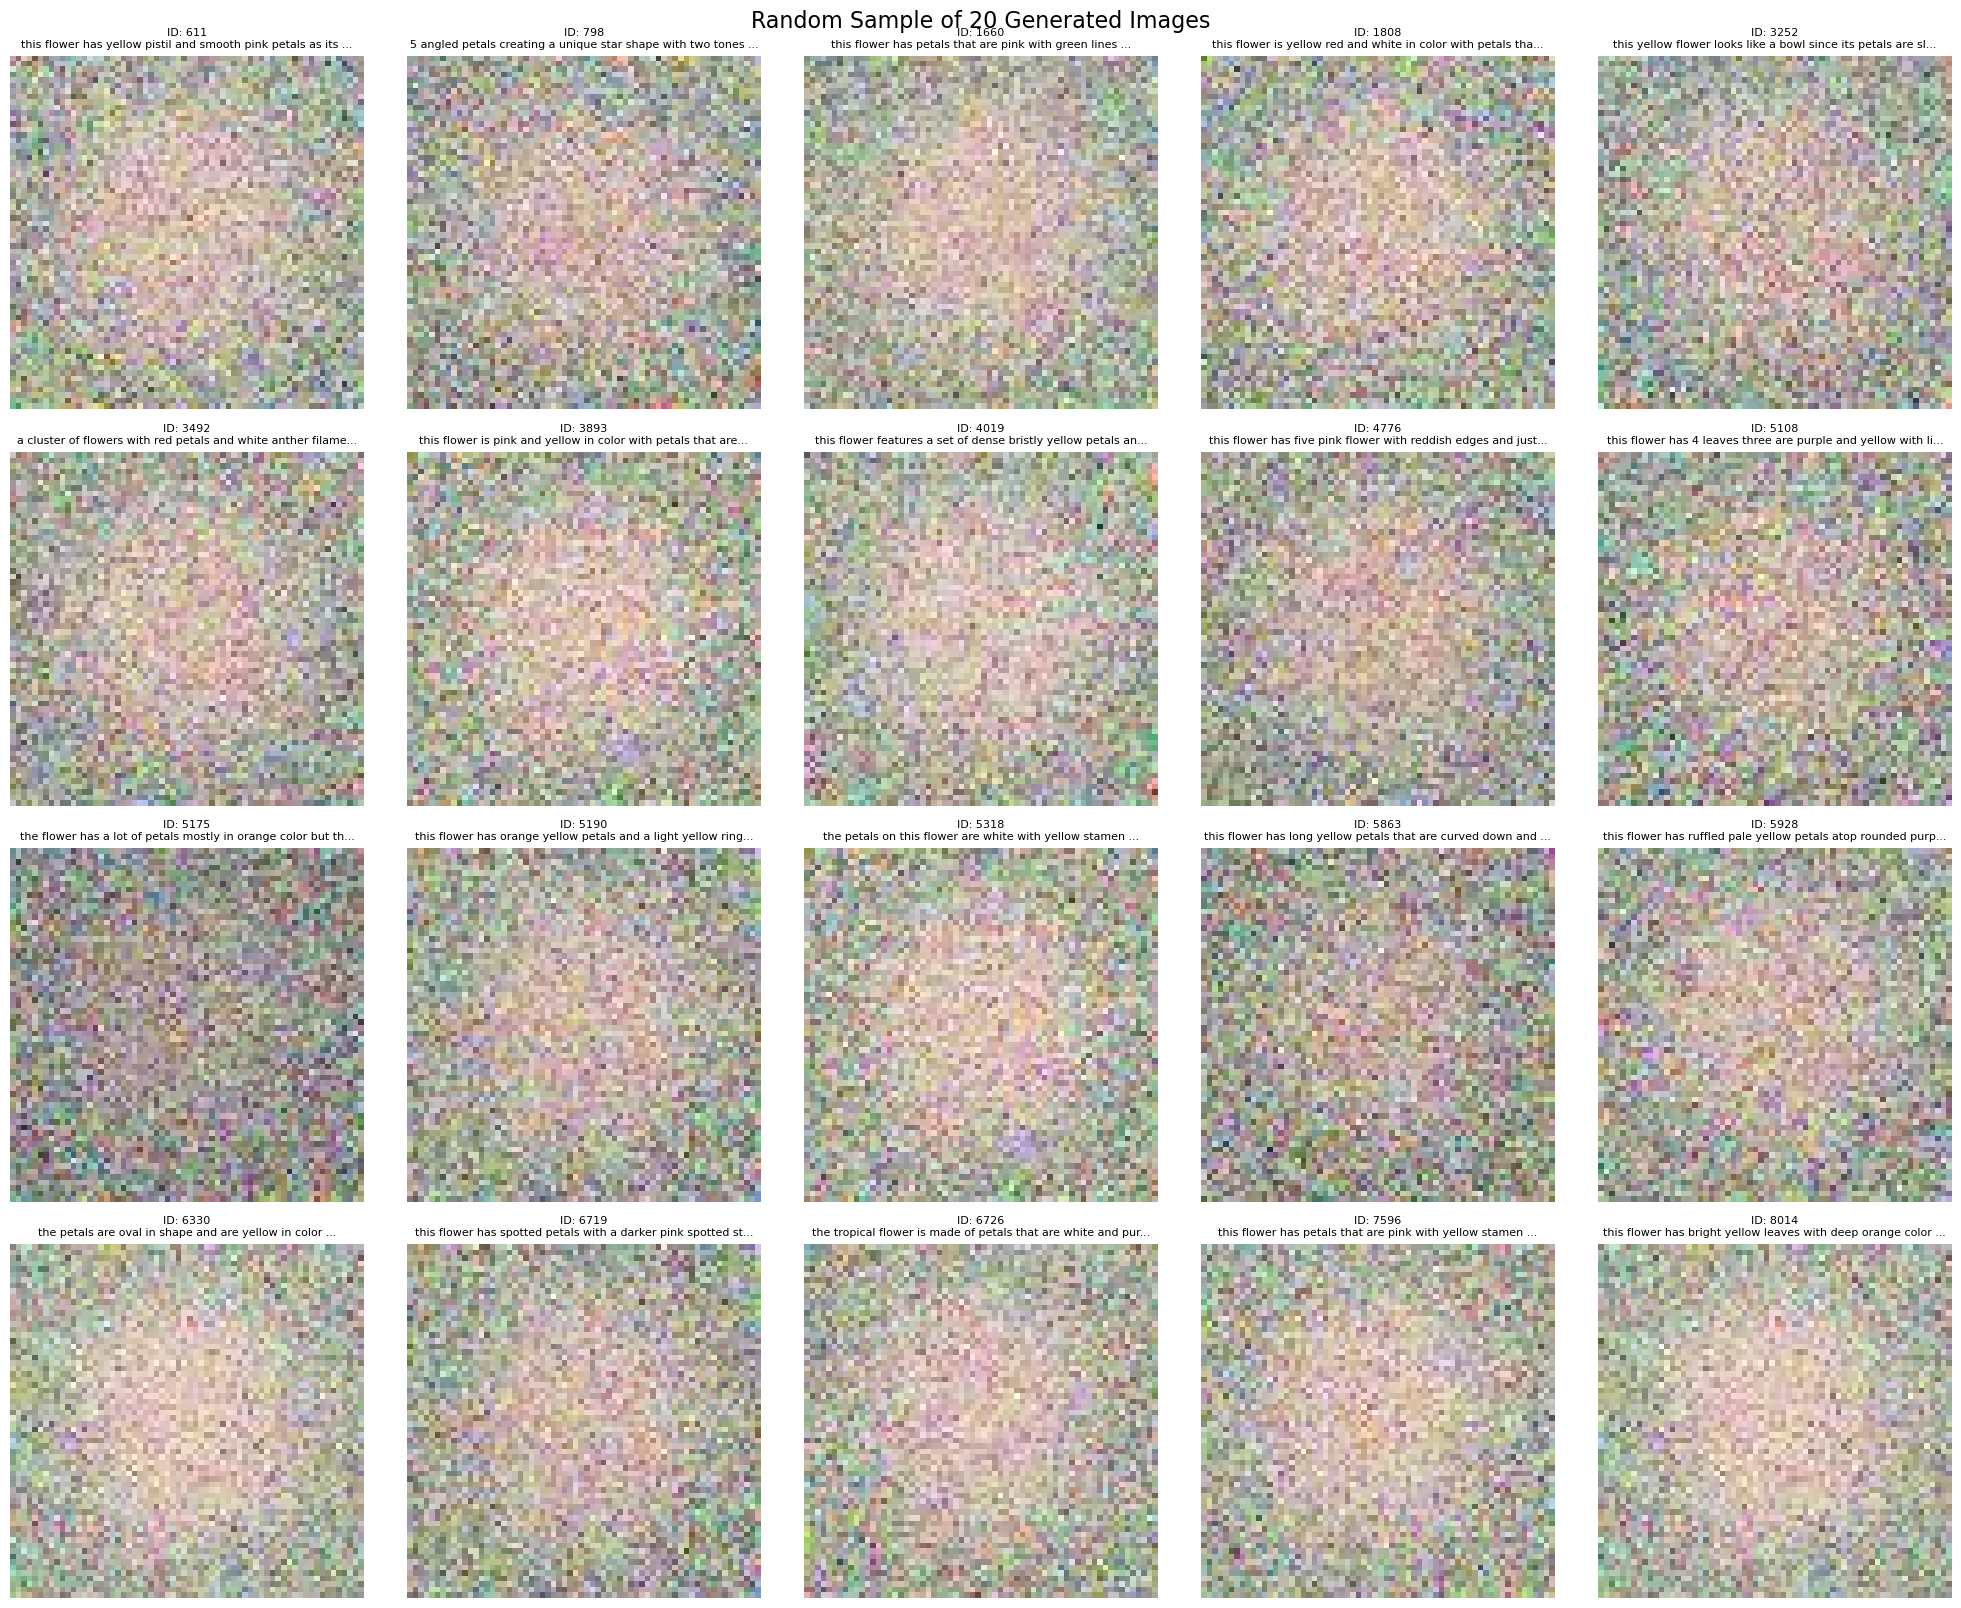


Total generated images: 819
Images directory: runs/20251115-170831/inference


In [94]:
# Visualize 20 random generated images with their captions
import glob

# Load test data
data = pd.read_pickle('./dataset/testData.pkl')
test_captions = data['Captions'].values
test_ids = data['ID'].values

# Get all generated images from the current inference directory
image_files = sorted(glob.glob(inference_dir + '/inference_*.jpg'))

if len(image_files) == 0:
    print(f'⚠ No images found in {inference_dir}')
    print('Please run the inference cell first!')
else:
    # Randomly sample 20 images
    np.random.seed(42)  # For reproducibility
    num_samples = min(20, len(image_files))
    sample_indices = np.random.choice(len(image_files), size=num_samples, replace=False)
    sample_files = [image_files[i] for i in sorted(sample_indices)]

    # Create 4x5 grid
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_files):
        # Extract image ID from filename
        img_id = int(Path(img_path).stem.split('_')[1])
        
        # Find caption
        caption_idx = np.where(test_ids == img_id)[0][0]
        caption_ids = test_captions[caption_idx]
        
        # Decode caption
        caption_text = ''
        for word_id in caption_ids:
            word = id2word_dict[str(word_id)]
            if word != '<PAD>':
                caption_text += word + ' '
        
        # Load and display image
        img = plt.imread(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f'ID: {img_id}\n{caption_text[:60]}...', fontsize=8)
        axes[idx].axis('off')

    # Hide unused subplots if less than 20 images
    for idx in range(num_samples, 20):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.suptitle(f'Random Sample of {num_samples} Generated Images', fontsize=16, y=1.002)
    plt.show()

    print(f'\nTotal generated images: {len(image_files)}')
    print(f'Images directory: {inference_dir}')